# Week 8. Data Aggregation and Group Operations

In [2]:
import numpy as np
import pandas as pd
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
np.random.seed(12345)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4, suppress=True)

One reason for the popularity of relational databases and SQL is the ease with which data can be joined, filtered, transformed, and aggregated. 

However, query languages like SQL are somewhat constrained in the kinds of group operations that can be performed. 

As you will see, with the expressiveness of Python and pandas, we can perform quite complex **group operations**. 

In this section, you will learn how to:
- (1) Split a pandas object into pieces using one or more keys (in the form of functions, arrays, or DataFrame column names);
- (2) Calculate group summary statistics, like count, mean, or standard deviation, or a user-defined function;
- (3) Apply within-group transformations or other manipulations, like normalization, linear regression, rank, or subset selection;
- (4) Compute pivot tables and cross-tabulations;
- (5) Perform quantile analysis and other statistical group analyses.

---

## 8.3 GroupBy Mechanics

Understanding **split-apply-combine**

* In the first stage, data contained in a pandas object, whether a Series, DataFrame, or otherwise, is split into groups based on one or more keys that you provide. 
  * The splitting is performed on a particular axis of an object. For example, a DataFrame can be grouped on its rows (```axis=0```) or its columns (```axis=1```). 
* Once this is done, a function is applied to each group, producing a new value. 
* Finally, the results of all those function applications are combined into a result object. 

In [2]:
data = pd.DataFrame({'key':['A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C'], 
                     'data':[0, 5, 10, 5, 10, 15, 10, 15, 20]})
data

,key,data
0,A,0
1,B,5
2,C,10
3,A,5
4,B,10
5,C,15
6,A,10
7,B,15
8,C,20


In [3]:
data.groupby('key').sum()

,data
key,
A,15
B,30
C,45


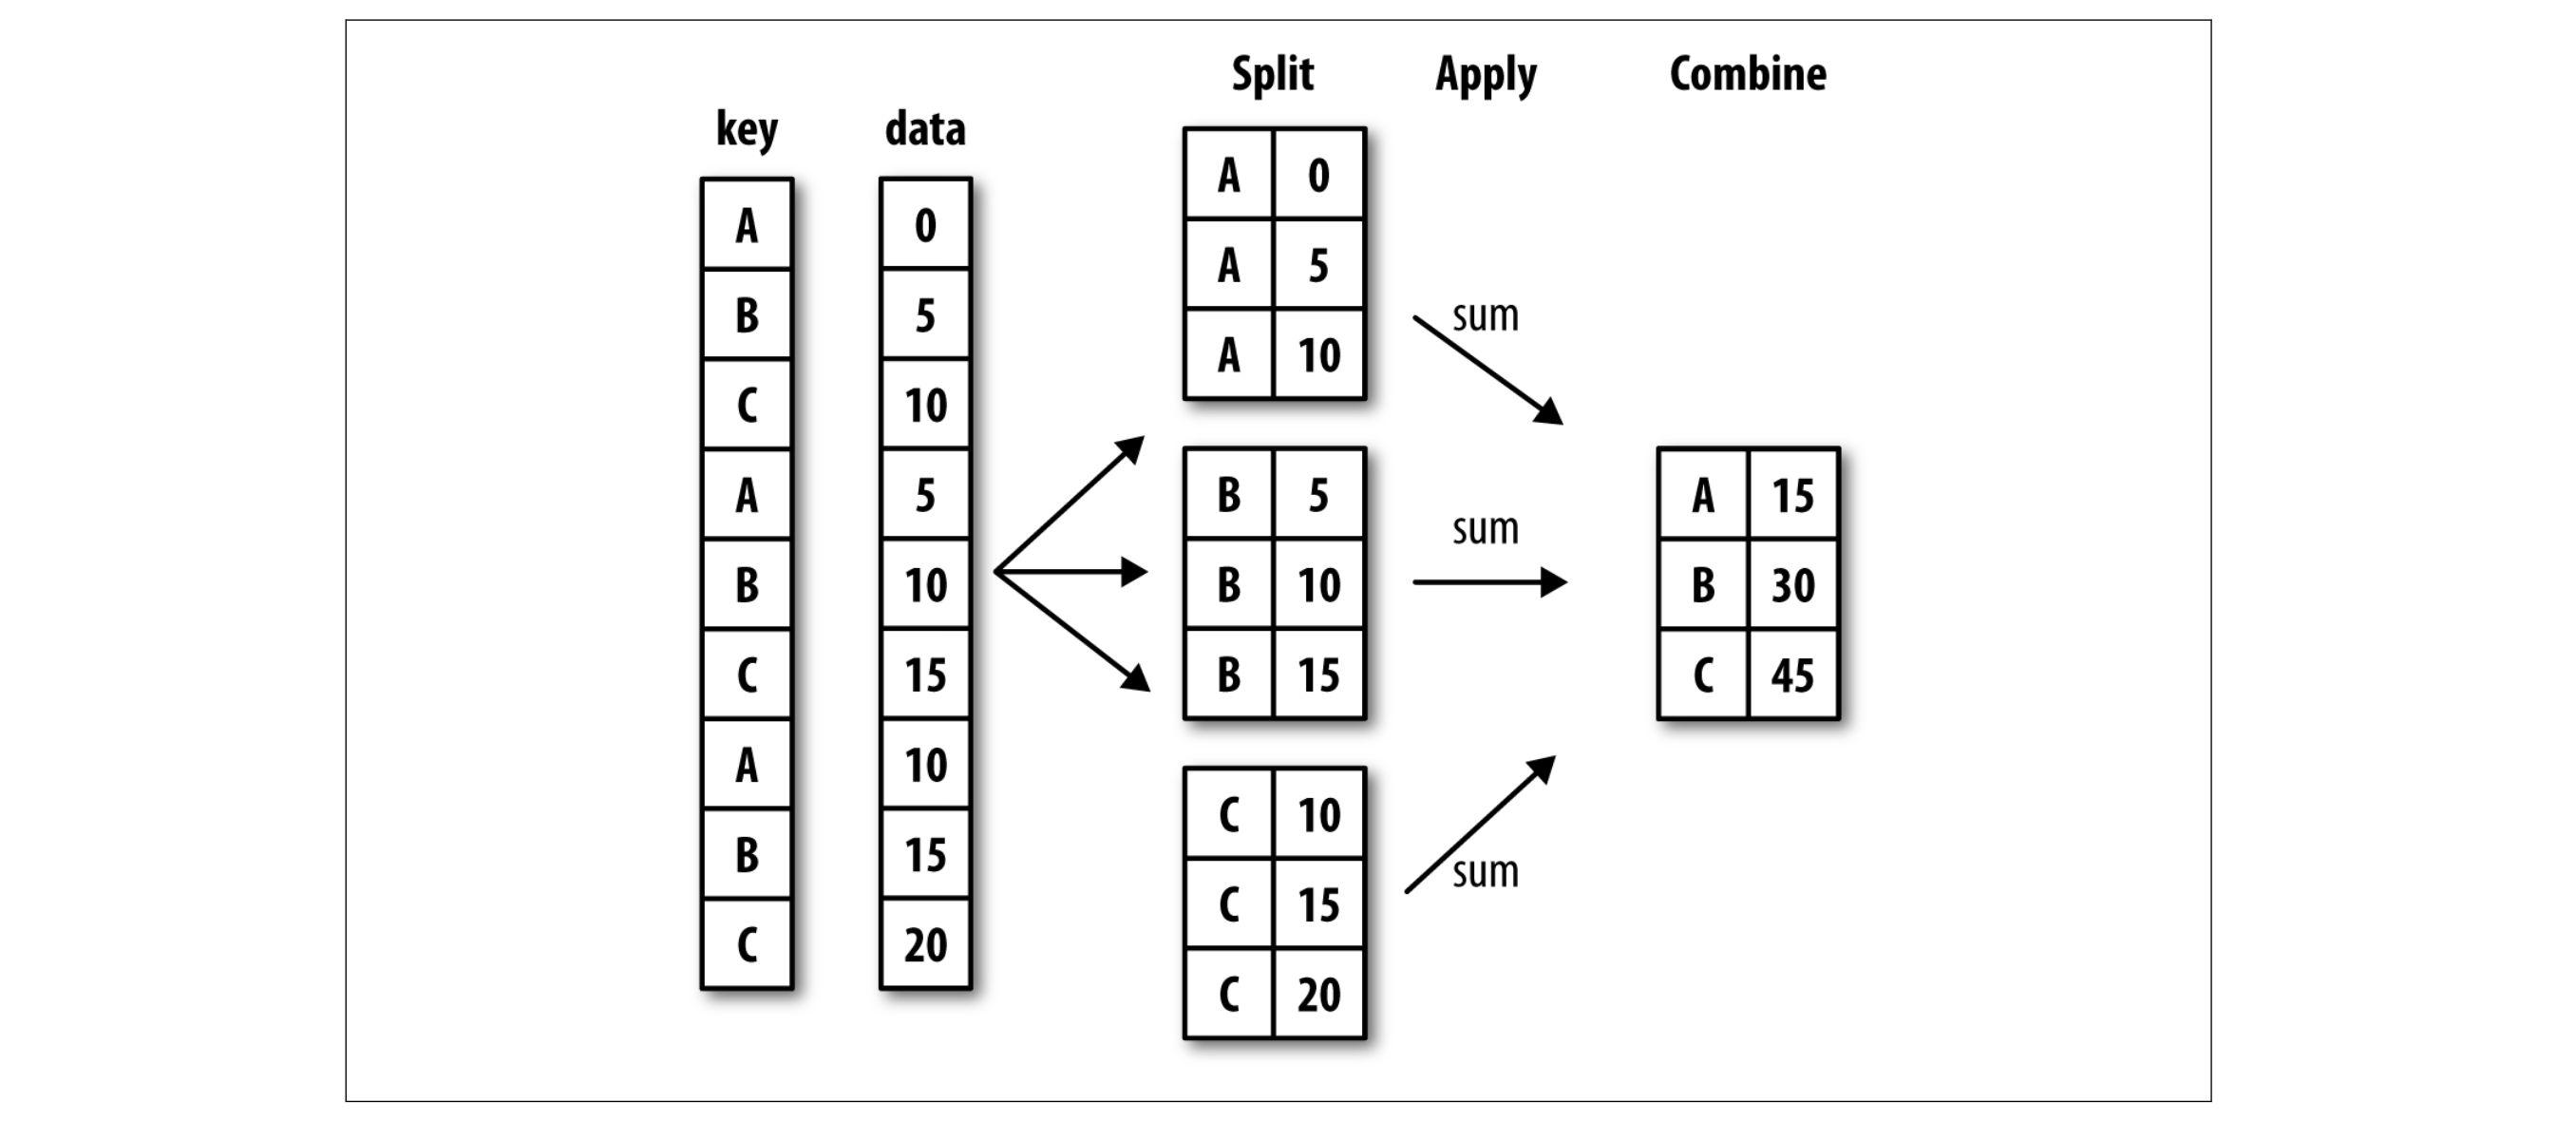

#### Each grouping key can take many forms
* A list or array of values that is the same length as the axis being grouped
* A value indicating a column name in a DataFrame
* A ```dict``` or ```Series``` giving a correspondence between the values on the axis being grouped and the group names
* A function to be invoked on the axis index or the individual labels in the index

In [3]:
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                   'key2' : ['one', 'two', 'one', 'two', 'one'],
                   'data1' : np.random.randn(5),
                   'data2' : np.random.randn(5)})
df

,key1,key2,data1,data2
0,a,one,-0.204708,1.393406
1,a,two,0.478943,0.092908
2,b,one,-0.519439,0.281746
3,b,two,-0.555730,0.769023
4,a,one,1.965781,1.246435


In [5]:
grouped = df['data1'].groupby(df['key1'])
grouped

* The above ```grouped``` variable is now a *GroupBy* object.   <br>
<br>
* It has not actually computed anything yet except for some intermediate data about the group key ```df['key1']```.  <br>
<br>
* The idea is that this object has all of the information needed to then apply some operation to each of the groups. 
  * For example, to compute group means we can call the GroupBy’s ```mean``` method:

In [6]:
grouped.mean()

key1
a    0.746672
b   -0.537585
Name: data1, dtype: float64

We grouped the data using two keys, and the resulting Series now has a **hierarchical index** consisting of the unique pairs of keys observed:

In [7]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
means

key1  key2
a     one     0.880536
      two     0.478943
b     one    -0.519439
      two    -0.555730
Name: data1, dtype: float64

In [8]:
means.unstack()

key2,one,two
key1,,
a,0.880536,0.478943
b,-0.519439,-0.555730


The grouping key can be a list or array of values that is the same length as the axis being grouped

In [9]:
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])
years = np.array([2005, 2005, 2006, 2005, 2006])
df['data1'].groupby([states, years]).mean()

California  2005    0.478943
            2006   -0.519439
Ohio        2005   -0.380219
            2006    1.965781
Name: data1, dtype: float64

In [10]:
df

,key1,key2,data1,data2
0,a,one,-0.204708,1.393406
1,a,two,0.478943,0.092908
2,b,one,-0.519439,0.281746
3,b,two,-0.555730,0.769023
4,a,one,1.965781,1.246435


In [11]:
df.groupby(['key1', 'key2']).mean()

data1     data2
key1 key2                    
a    one   0.880536  1.319920
     two   0.478943  0.092908
b    one  -0.519439  0.281746
     two  -0.555730  0.769023

In [12]:
# Another generally useful GroupBy method is size, which returns a Series containing group sizes:
df.groupby(['key1', 'key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

### 8.3.1 Iterating Over Groups

The GroupBy object supports iteration, generating a sequence of 2-tuples containing:
* the group name
* the chunk of data

In [13]:
for name, group in df.groupby('key1'):
    print('-------------------------------')
    print(name)
    print(group)

-------------------------------
a
  key1 key2     data1     data2
0    a  one -0.204708  1.393406
1    a  two  0.478943  0.092908
4    a  one  1.965781  1.246435
-------------------------------
b
  key1 key2     data1     data2
2    b  one -0.519439  0.281746
3    b  two -0.555730  0.769023


In the case of multiple keys, the first element in the tuple will be a **tuple of key values**:

In [14]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print('-------------------------------')
    print((k1, k2))
    print(group)

-------------------------------
('a', 'one')
  key1 key2     data1     data2
0    a  one -0.204708  1.393406
4    a  one  1.965781  1.246435
-------------------------------
('a', 'two')
  key1 key2     data1     data2
1    a  two  0.478943  0.092908
-------------------------------
('b', 'one')
  key1 key2     data1     data2
2    b  one -0.519439  0.281746
-------------------------------
('b', 'two')
  key1 key2    data1     data2
3    b  two -0.55573  0.769023


By default ```groupby``` groups on ```axis=0```, but you can group on any of the other axes. 
  * For example, we could group the columns of our example ```df``` here by ```dtype``` like so:

In [17]:
df.dtypes

key1      object
key2      object
data1    float64
data2    float64
dtype: object

In [18]:
grouped = df.groupby(df.dtypes, axis=1)

In [19]:
for dtype, group in grouped:
    print(dtype)
    print(group)

float64
      data1     data2
0 -0.204708  1.393406
1  0.478943  0.092908
2 -0.519439  0.281746
3 -0.555730  0.769023
4  1.965781  1.246435
object
  key1 key2
0    a  one
1    a  two
2    b  one
3    b  two
4    a  one


### 8.3.2 Selecting a Column or Subset of Columns

* Indexing a GroupBy object created from a DataFrame with a column name or array of column names has the effect of column subsetting for aggregation.  <br>
<br>
* ```df[['data2']]``` is different from ```df['data2']``` in the sense that the former one is a data frame but the latter one is series. 

In [20]:
df.groupby(['key1', 'key2'])[['data2']].mean()

data2
key1 key2          
a    one   1.319920
     two   0.092908
b    one   0.281746
     two   0.769023

In [21]:
s_grouped = df.groupby(['key1', 'key2'])['data2']
s_grouped

In [22]:
s_grouped.mean()    # of type pd.Series

key1  key2
a     one     1.319920
      two     0.092908
b     one     0.281746
      two     0.769023
Name: data2, dtype: float64

### 8.3.3 Grouping with Dicts and Series

In [23]:
people = pd.DataFrame(np.random.randn(5, 5),
                      columns=['a', 'b', 'c', 'd', 'e'],
                      index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])
people.iloc[2:3, [1, 2]] = np.nan   # Add a few NA values
people

,a,b,c,d,e
Joe,1.007189,-1.296221,0.274992,0.228913,1.352917
Steve,0.886429,-2.001637,-0.371843,1.669025,-0.438570
Wes,-0.539741,NaN,NaN,-1.021228,-0.577087
Jim,0.124121,0.302614,0.523772,0.000940,1.343810
Travis,-0.713544,-0.831154,-2.370232,-1.860761,-0.860757


Now, you could construct an array from this dict to pass to groupby, but instead we can just pass the dict 
 * I included the key ```'f'``` to highlight that unused grouping keys are OK. 

In [24]:
mapping = {'a': 'red', 'b': 'red', 'c': 'blue',
           'd': 'blue', 'e': 'red', 'f' : 'orange'}  # Note that we don't have 'f' in 'people'
by_column = people.groupby(mapping, axis=1)   # 'axis=1' means sort by columns
by_column.sum()

,blue,red
Joe,0.503905,1.063885
Steve,1.297183,-1.553778
Wes,-1.021228,-1.116829
Jim,0.524712,1.770545
Travis,-4.230992,-2.405455


### 8.3.4 Grouping with Functions

* Using Python functions is a more generic way of defining a group mapping compared with a dict or Series. <br>
<br>
* Any function passed as a group key will be called once **per index value**, with the return values being used as the group names.  <br>
<br>
* Consider the example DataFrame from the previous section, which has people’s first names as index values. **Suppose you wanted to group by the length of the names**.  

In [25]:
people

,a,b,c,d,e
Joe,1.007189,-1.296221,0.274992,0.228913,1.352917
Steve,0.886429,-2.001637,-0.371843,1.669025,-0.438570
Wes,-0.539741,NaN,NaN,-1.021228,-0.577087
Jim,0.124121,0.302614,0.523772,0.000940,1.343810
Travis,-0.713544,-0.831154,-2.370232,-1.860761,-0.860757


In [26]:
people.groupby(len).sum()

,a,b,c,d,e
3,0.591569,-0.993608,0.798764,-0.791374,2.119639
5,0.886429,-2.001637,-0.371843,1.669025,-0.438570
6,-0.713544,-0.831154,-2.370232,-1.860761,-0.860757


You can even mix functions with arrays, dicts, or Series: 

In [27]:
key_list = ['one', 'one', 'one', 'two', 'two']
people.groupby([len, key_list]).min()

a         b         c         d         e
3 one -0.539741 -1.296221  0.274992 -1.021228 -0.577087
  two  0.124121  0.302614  0.523772  0.000940  1.343810
5 one  0.886429 -2.001637 -0.371843  1.669025 -0.438570
6 two -0.713544 -0.831154 -2.370232 -1.860761 -0.860757

### 8.3.5 Grouping by Index Levels

A final convenience for hierarchically indexed datasets is the ability to **aggregate using one of the levels of an axis index**.

In [34]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
                                    [1, 3, 5, 1, 3]],
                                    names=['cty', 'tenor'])
hier_df = pd.DataFrame(np.random.randn(4, 5), columns=columns)
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0      0.560145 -1.265934  0.119827 -1.063512  0.332883
1     -2.359419 -0.199543 -1.541996 -0.970736 -1.307030
2      0.286350  0.377984 -0.753887  0.331286  1.349742
3      0.069877  0.246674 -0.011862  1.004812  1.327195

In [35]:
hier_df.groupby(level='cty', axis=1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


In [36]:
hier_df.groupby(level=0, axis=1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


---

## 8.4 Data Aggregation

Aggregations refer to any data transformation that produces scalar values from arrays. The preceding examples have used several of them, including ```mean```, ```count```, ```min```, and ```sum```.

In [37]:
df

,key1,key2,data1,data2
0,a,one,-0.204708,1.393406
1,a,two,0.478943,0.092908
2,b,one,-0.519439,0.281746
3,b,two,-0.555730,0.769023
4,a,one,1.965781,1.246435


In [40]:
grouped = df[['key1','data1','data2']].groupby('key1')
grouped['data1'].quantile(0.9)

key1
a    1.668413
b   -0.523068
Name: data1, dtype: float64

To use **your own** aggregation functions, pass any function that aggregates an array to the ```aggregate``` or ```agg``` method:

In [41]:
def peak_to_peak(arr):
    return arr.max() - arr.min()
grouped.agg(peak_to_peak)

,data1,data2
key1,,
a,2.170488,1.300498
b,0.036292,0.487276


In [42]:
grouped.describe()

data1                                                              \
     count      mean       std       min       25%       50%       75%   
key1                                                                     
a      3.0  0.746672  1.109736 -0.204708  0.137118  0.478943  1.222362   
b      2.0 -0.537585  0.025662 -0.555730 -0.546657 -0.537585 -0.528512   

               data2                                                    \
           max count      mean       std       min       25%       50%   
key1                                                                     
a     1.965781   3.0  0.910916  0.712217  0.092908  0.669671  1.246435   
b    -0.519439   2.0  0.525384  0.344556  0.281746  0.403565  0.525384   

                          
           75%       max  
key1                      
a     1.319920  1.393406  
b     0.647203  0.769023

### 8.4.1 Column-Wise and Multiple Function Application

In [43]:
tips = pd.read_csv('data/tips.csv')
# Add tip percentage of total bill
tips['tip_pct'] = tips['tip'] / tips['total_bill']
tips[:6]

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808
5,25.29,4.71,No,Sun,Dinner,4,0.186240


Aggregating a Series or all of the columns of a DataFrame is a matter of using ```aggregate``` with the desired function or calling a method like ```mean```.

In [44]:
grouped = tips.groupby(['day', 'smoker'])

In [45]:
grouped_pct = grouped['tip_pct']
grouped_pct.agg('mean')

day   smoker
Fri   No        0.151650
      Yes       0.174783
Sat   No        0.158048
      Yes       0.147906
Sun   No        0.160113
      Yes       0.187250
Thur  No        0.160298
      Yes       0.163863
Name: tip_pct, dtype: float64

If you pass **a list of functions or function names**, you get back a DataFrame with column names taken from the functions:

In [46]:
grouped_pct.agg(['mean', 'std', peak_to_peak])  # we passed a list of aggregation functions to agg to 
                                                # evaluate indepedently on the data groups.

mean       std  peak_to_peak
day  smoker                                  
Fri  No      0.151650  0.028123      0.067349
     Yes     0.174783  0.051293      0.159925
Sat  No      0.158048  0.039767      0.235193
     Yes     0.147906  0.061375      0.290095
Sun  No      0.160113  0.042347      0.193226
     Yes     0.187250  0.154134      0.644685
Thur No      0.160298  0.038774      0.193350
     Yes     0.163863  0.039389      0.151240

If you pass **a list of (name, function) tuples**, the first element of each tuple will be used as the DataFrame column names. 

In [47]:
grouped_pct.agg([('foo', 'mean'), ('bar', np.std)])

foo       bar
day  smoker                    
Fri  No      0.151650  0.028123
     Yes     0.174783  0.051293
Sat  No      0.158048  0.039767
     Yes     0.147906  0.061375
Sun  No      0.160113  0.042347
     Yes     0.187250  0.154134
Thur No      0.160298  0.038774
     Yes     0.163863  0.039389

* With a DataFrame you have more options, as you can specify a list of functions to apply to all of the columns or different functions per column. <br>
<br>
* To start, suppose we wanted to compute the same three statistics for the ```tip_pct``` and ```total_bill``` columns.

In [49]:
functions = ['count', 'mean', 'max']
result = grouped[['tip_pct', 'total_bill']].agg(functions)
result

tip_pct                     total_bill                  
              count      mean       max      count       mean    max
day  smoker                                                         
Fri  No           4  0.151650  0.187735          4  18.420000  22.75
     Yes         15  0.174783  0.263480         15  16.813333  40.17
Sat  No          45  0.158048  0.291990         45  19.661778  48.33
     Yes         42  0.147906  0.325733         42  21.276667  50.81
Sun  No          57  0.160113  0.252672         57  20.506667  48.17
     Yes         19  0.187250  0.710345         19  24.120000  45.35
Thur No          45  0.160298  0.266312         45  17.113111  41.19
     Yes         17  0.163863  0.241255         17  19.190588  43.11

As before, a list of tuples with **custom names** can be passed:

In [51]:
ftuples = [('Durchschnitt', 'mean'), ('Abweichung', np.var)]
grouped[['tip_pct', 'total_bill']].agg(ftuples)

tip_pct              total_bill            
            Durchschnitt Abweichung Durchschnitt  Abweichung
day  smoker                                                 
Fri  No         0.151650   0.000791    18.420000   25.596333
     Yes        0.174783   0.002631    16.813333   82.562438
Sat  No         0.158048   0.001581    19.661778   79.908965
     Yes        0.147906   0.003767    21.276667  101.387535
Sun  No         0.160113   0.001793    20.506667   66.099980
     Yes        0.187250   0.023757    24.120000  109.046044
Thur No         0.160298   0.001503    17.113111   59.625081
     Yes        0.163863   0.001551    19.190588   69.808518

Now, suppose you wanted to apply potentially different functions to one or more of the columns. To do this, pass a dict to ```agg``` that contains a mapping of column names to any of the function specifications listed so far.

In [50]:
grouped.agg({'tip' : np.max, 'size' : 'sum'})

tip  size
day  smoker             
Fri  No       3.50     9
     Yes      4.73    31
Sat  No       9.00   115
     Yes     10.00   104
Sun  No       6.00   167
     Yes      6.50    49
Thur No       6.70   112
     Yes      5.00    40

In [51]:
grouped.agg({'tip_pct' : ['min', 'max', 'mean', 'std'],
             'size' : 'sum'})

tip_pct                               size
                  min       max      mean       std  sum
day  smoker                                             
Fri  No      0.120385  0.187735  0.151650  0.028123    9
     Yes     0.103555  0.263480  0.174783  0.051293   31
Sat  No      0.056797  0.291990  0.158048  0.039767  115
     Yes     0.035638  0.325733  0.147906  0.061375  104
Sun  No      0.059447  0.252672  0.160113  0.042347  167
     Yes     0.065660  0.710345  0.187250  0.154134   49
Thur No      0.072961  0.266312  0.160298  0.038774  112
     Yes     0.090014  0.241255  0.163863  0.039389   40

### 8.4.2 Returning Aggregated Data Without Row Indexes

In [52]:
tips.groupby(['day', 'smoker'], as_index=False).mean()

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,18.420000,2.812500,2.250000,0.151650
1,Fri,Yes,16.813333,2.714000,2.066667,0.174783
2,Sat,No,19.661778,3.102889,2.555556,0.158048
3,Sat,Yes,21.276667,2.875476,2.476190,0.147906
4,Sun,No,20.506667,3.167895,2.929825,0.160113
5,Sun,Yes,24.120000,3.516842,2.578947,0.187250
6,Thur,No,17.113111,2.673778,2.488889,0.160298
7,Thur,Yes,19.190588,3.030000,2.352941,0.163863


---

## 8.5 Apply: General split-apply-combine

The most general-purpose GroupBy method is ```apply```. 

Returning to the tipping dataset from before, suppose you wanted to select **the top five ```tip_pct``` values** by group. First, write a function that selects the rows with the largest values in a particular column:

In [52]:
def top(df, n=5, column='tip_pct'):
    return df.sort_values(by=column)[-n:]

top(tips, n=6)

,total_bill,tip,smoker,day,time,size,tip_pct
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


Now, if we group by smoker, say, and call ```apply``` with this function

In [53]:
tips.groupby('smoker').apply(top)

total_bill   tip smoker   day    time  size   tip_pct
smoker                                                           
No     88        24.71  5.85     No  Thur   Lunch     2  0.236746
       185       20.69  5.00     No   Sun  Dinner     5  0.241663
       51        10.29  2.60     No   Sun  Dinner     2  0.252672
       149        7.51  2.00     No  Thur   Lunch     2  0.266312
       232       11.61  3.39     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Yes   Sun  Dinner     2  0.710345

What has happened here? 

The top function is called on each row group from the DataFrame, and then the results are glued together using ```pandas.concat```, labeling the pieces with the group names. The result therefore has a hierarchical index whose inner level contains index values from the original DataFrame.

If you pass a function to ```apply``` that takes other arguments or keywords, you can pass these after the function:

In [54]:
tips.groupby(['smoker', 'day']).apply(top, n=1, column='total_bill')

total_bill    tip smoker   day    time  size   tip_pct
smoker day                                                             
No     Fri  94        22.75   3.25     No   Fri  Dinner     2  0.142857
       Sat  212       48.33   9.00     No   Sat  Dinner     4  0.186220
       Sun  156       48.17   5.00     No   Sun  Dinner     6  0.103799
       Thur 142       41.19   5.00     No  Thur   Lunch     5  0.121389
Yes    Fri  95        40.17   4.73    Yes   Fri  Dinner     4  0.117750
       Sat  170       50.81  10.00    Yes   Sat  Dinner     3  0.196812
       Sun  182       45.35   3.50    Yes   Sun  Dinner     3  0.077178
       Thur 197       43.11   5.00    Yes  Thur   Lunch     4  0.115982

In [55]:
result = tips.groupby('smoker')['tip_pct'].describe()
result

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
No,151.0,0.159328,0.039910,0.056797,0.136906,0.155625,0.185014,0.291990
Yes,93.0,0.163196,0.085119,0.035638,0.106771,0.153846,0.195059,0.710345


In [56]:
result.unstack('smoker')

       smoker
count  No        151.000000
       Yes        93.000000
mean   No          0.159328
       Yes         0.163196
std    No          0.039910
       Yes         0.085119
min    No          0.056797
       Yes         0.035638
25%    No          0.136906
       Yes         0.106771
50%    No          0.155625
       Yes         0.153846
75%    No          0.185014
       Yes         0.195059
max    No          0.291990
       Yes         0.710345
dtype: float64

### 8.5.1 Suppressing the Group Keys

In the preceding examples, you see that the resulting object has a hierarchical index formed from the group keys along with the indexes of each piece of the original object. 

You can disable this by passing ```group_keys=False``` to groupby:

In [57]:
tips.groupby('smoker', group_keys=False).apply(top)

,total_bill,tip,smoker,day,time,size,tip_pct
88,24.71,5.85,No,Thur,Lunch,2,0.236746
185,20.69,5.00,No,Sun,Dinner,5,0.241663
51,10.29,2.60,No,Sun,Dinner,2,0.252672
149,7.51,2.00,No,Thur,Lunch,2,0.266312
232,11.61,3.39,No,Sat,Dinner,2,0.291990
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


### 8.5.2 Quantile and Bucket Analysis (```cut``` and ```qcut```)

In [58]:
frame = pd.DataFrame({'data1': np.random.randn(1000),
                      'data2': np.random.randn(1000)})
quartiles = pd.cut(frame.data1, 4)
quartiles[:10]     # The Categorical object returned by cut can be passed directly to groupby

0     (-1.23, 0.489]
1    (-2.956, -1.23]
2     (-1.23, 0.489]
3     (0.489, 2.208]
4     (-1.23, 0.489]
5     (0.489, 2.208]
6     (-1.23, 0.489]
7     (-1.23, 0.489]
8     (0.489, 2.208]
9     (0.489, 2.208]
Name: data1, dtype: category
Categories (4, interval[float64, right]): [(-2.956, -1.23] < (-1.23, 0.489] < (0.489, 2.208] < (2.208, 3.928]]

The ```Categorical``` object returned by ```cut``` can be passed directly to ```groupby```.

In [59]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}


In [60]:
grouped = frame.data2.groupby(quartiles)
grouped.apply(get_stats)

data1                 
(-2.956, -1.23]  min       -3.399312
                 max        1.670835
                 count     95.000000
                 mean      -0.039521
(-1.23, 0.489]   min       -2.989741
                 max        3.260383
                 count    598.000000
                 mean      -0.002051
(0.489, 2.208]   min       -3.745356
                 max        2.954439
                 count    297.000000
                 mean       0.081822
(2.208, 3.928]   min       -1.929776
                 max        1.765640
                 count     10.000000
                 mean       0.024750
Name: data2, dtype: float64

In [61]:
grouped.apply(get_stats).unstack()

,min,max,count,mean
data1,,,,
"(-2.956, -1.23]",-3.399312,1.670835,95.0,-0.039521
"(-1.23, 0.489]",-2.989741,3.260383,598.0,-0.002051
"(0.489, 2.208]",-3.745356,2.954439,297.0,0.081822
"(2.208, 3.928]",-1.929776,1.765640,10.0,0.024750


In [62]:
# Return quantile numbers
grouping = pd.qcut(frame.data1, 10, labels=None)   # set labels=False
grouped = frame.data2.groupby(grouping)
grouped.apply(get_stats).unstack()

,min,max,count,mean
data1,,,,
"(-2.9499999999999997, -1.191]",-3.399312,1.670835,100.0,-0.049902
"(-1.191, -0.881]",-1.950098,2.628441,100.0,0.030989
"(-0.881, -0.553]",-2.925113,2.527939,100.0,-0.067179
"(-0.553, -0.303]",-2.315555,3.260383,100.0,0.065713
"(-0.303, -0.029]",-2.047939,2.074345,100.0,-0.111653
"(-0.029, 0.213]",-2.989741,2.184810,100.0,0.052130
"(0.213, 0.503]",-2.223506,2.458842,100.0,-0.021489
"(0.503, 0.802]",-3.056990,2.954439,100.0,-0.026459
"(0.802, 1.286]",-3.745356,2.735527,100.0,0.103406


### Example: Filling Missing Values with Group-Specific       Values

In [63]:
s = pd.Series(np.random.randn(6))
s[::2] = np.nan
s

0         NaN
1   -0.125921
2         NaN
3   -0.884475
4         NaN
5    0.227290
dtype: float64

In [64]:
s.fillna(s.mean())

0   -0.261035
1   -0.125921
2   -0.261035
3   -0.884475
4   -0.261035
5    0.227290
dtype: float64

In [65]:
states = ['Ohio', 'New York', 'Vermont', 'Florida',
          'Oregon', 'Nevada', 'California', 'Idaho']
group_key = ['East'] * 4 + ['West'] * 4
data = pd.Series(np.random.randn(8), index=states)
data

Ohio          0.922264
New York     -2.153545
Vermont      -0.365757
Florida      -0.375842
Oregon        0.329939
Nevada        0.981994
California    1.105913
Idaho        -1.613716
dtype: float64

In [66]:
data[['Vermont', 'Nevada', 'Idaho']] = np.nan
data

Ohio          0.922264
New York     -2.153545
Vermont            NaN
Florida      -0.375842
Oregon        0.329939
Nevada             NaN
California    1.105913
Idaho              NaN
dtype: float64

We can fill the NA values using the group means like so:

In [67]:
data.groupby(group_key).mean()

East   -0.535707
West    0.717926
dtype: float64

In [68]:
fill_mean = lambda g: g.fillna(g.mean())
data.groupby(group_key).apply(fill_mean)

East  Ohio          0.922264
      New York     -2.153545
      Vermont      -0.535707
      Florida      -0.375842
West  Oregon        0.329939
      Nevada        0.717926
      California    1.105913
      Idaho         0.717926
dtype: float64

In another case, you might have predefined fill values in your code that vary by group.

In [69]:
fill_values = {'East': 0.5, 'West': -1}
fill_func = lambda g: g.fillna(fill_values[g.name])
data.groupby(group_key).apply(fill_func)

East  Ohio          0.922264
      New York     -2.153545
      Vermont       0.500000
      Florida      -0.375842
West  Oregon        0.329939
      Nevada       -1.000000
      California    1.105913
      Idaho        -1.000000
dtype: float64

### Example: Group Weighted Average and Correlation

In [74]:
df = pd.DataFrame({'category': ['a', 'a', 'a', 'a',
                                'b', 'b', 'b', 'b'],
                   'data': np.random.randn(8),
                   'weights': np.random.rand(8)})
df

,category,data,weights
0,a,1.561587,0.779796
1,a,0.022100,0.422211
2,a,0.546344,0.962321
3,a,0.385143,0.051641
4,b,0.303070,0.329897
5,b,-0.346796,0.576990
6,b,-0.317939,0.517064
7,b,-0.245498,0.337359


In [75]:
grouped = df.groupby('category')
get_wavg = lambda g: np.average(g['data'], weights=g['weights'])
grouped.apply(get_wavg)

category
a    0.799965
b   -0.197201
dtype: float64

In [76]:
close_px = pd.read_csv('data/stock_px_2.csv', parse_dates=True, index_col=0)
close_px.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2214 entries, 2003-01-02 to 2011-10-14
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2214 non-null   float64
 1   MSFT    2214 non-null   float64
 2   XOM     2214 non-null   float64
 3   SPX     2214 non-null   float64
dtypes: float64(4)
memory usage: 86.5 KB


In [77]:
close_px[-4:]

,AAPL,MSFT,XOM,SPX
2011-10-11,400.29,27.00,76.27,1195.54
2011-10-12,402.19,26.96,77.16,1207.25
2011-10-13,408.43,27.18,76.37,1203.66
2011-10-14,422.00,27.27,78.11,1224.58


In [78]:
spx_corr = lambda x: x.corrwith(x['SPX'])

In [79]:
rets = close_px.pct_change().dropna()   # compute percent change on close_px using pct_change

Lastly, we group these percent changes by year, which can be extracted from each row label with a one-line function that returns the ```year``` attribute of each ```datetime``` label:

In [80]:
get_year = lambda x: x.year
by_year = rets.groupby(get_year)
by_year.apply(spx_corr)

,AAPL,MSFT,XOM,SPX
2003,0.541124,0.745174,0.661265,1.0
2004,0.374283,0.588531,0.557742,1.0
2005,0.467540,0.562374,0.631010,1.0
2006,0.428267,0.406126,0.518514,1.0
2007,0.508118,0.658770,0.786264,1.0
2008,0.681434,0.804626,0.828303,1.0
2009,0.707103,0.654902,0.797921,1.0
2010,0.710105,0.730118,0.839057,1.0
2011,0.691931,0.800996,0.859975,1.0


You could also compute **inter-column correlations**. Here we compute the annual correlation between Apple and Microsoft:

In [81]:
by_year.apply(lambda g: g['AAPL'].corr(g['MSFT']))

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

### Example: Group-Wise Linear Regression

I can define the following regress function (using the ```statsmodels``` econometrics library), which executes an ordinary least squares (OLS) regression on each chunk of data:

In [82]:
import statsmodels.api as sm

In [83]:
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

Now, to run a yearly linear regression of AAPL on SPX returns, execute:

In [84]:
by_year.apply(regress, 'AAPL', ['SPX'])

,SPX,intercept
2003,1.195406,0.000710
2004,1.363463,0.004201
2005,1.766415,0.003246
2006,1.645496,0.000080
2007,1.198761,0.003438
2008,0.968016,-0.001110
2009,0.879103,0.002954
2010,1.052608,0.001261
2011,0.806605,0.001514


---

## 8.6 Pivot Tables and Cross-Tabulation

A ***pivot table*** aggregates a table of data by one or more keys, arranging the data in a rectangle with some of the group keys along the rows and some along the columns.

Returning to the tipping dataset, suppose you wanted to compute a table of group means (the default ```pivot_table``` aggregation type) arranged by ```day``` and ```smoker``` on the rows:

In [88]:
tips

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808
...,...,...,...,...,...,...,...
239,29.03,5.92,No,Sat,Dinner,3,0.203927
240,27.18,2.00,Yes,Sat,Dinner,2,0.073584
241,22.67,2.00,Yes,Sat,Dinner,2,0.088222
242,17.82,1.75,No,Sat,Dinner,2,0.098204


In [79]:
tips.pivot_table(index=['day', 'smoker'])

size       tip   tip_pct  total_bill
day  smoker                                          
Fri  No      2.250000  2.812500  0.151650   18.420000
     Yes     2.066667  2.714000  0.174783   16.813333
Sat  No      2.555556  3.102889  0.158048   19.661778
     Yes     2.476190  2.875476  0.147906   21.276667
Sun  No      2.929825  3.167895  0.160113   20.506667
     Yes     2.578947  3.516842  0.187250   24.120000
Thur No      2.488889  2.673778  0.160298   17.113111
     Yes     2.352941  3.030000  0.163863   19.190588

In [89]:
tips.pivot_table(['tip_pct', 'size'], index=['time', 'day'],
                 columns='smoker')   # put smoker in the table columns 

size             tip_pct          
smoker             No       Yes        No       Yes
time   day                                         
Dinner Fri   2.000000  2.222222  0.139622  0.165347
       Sat   2.555556  2.476190  0.158048  0.147906
       Sun   2.929825  2.578947  0.160113  0.187250
       Thur  2.000000       NaN  0.159744       NaN
Lunch  Fri   3.000000  1.833333  0.187735  0.188937
       Thur  2.500000  2.352941  0.160311  0.163863

We could augment this table to include **partial totals** by passing ```margins=True```. 

This has the effect of adding All row and column labels, with corresponding values being the group statistics for all the data within a single tier. 

In [90]:
tips.pivot_table(['tip_pct', 'size'], index=['time', 'day'],
                 columns='smoker', margins=True)   

size                       tip_pct                    
smoker             No       Yes       All        No       Yes       All
time   day                                                             
Dinner Fri   2.000000  2.222222  2.166667  0.139622  0.165347  0.158916
       Sat   2.555556  2.476190  2.517241  0.158048  0.147906  0.153152
       Sun   2.929825  2.578947  2.842105  0.160113  0.187250  0.166897
       Thur  2.000000       NaN  2.000000  0.159744       NaN  0.159744
Lunch  Fri   3.000000  1.833333  2.000000  0.187735  0.188937  0.188765
       Thur  2.500000  2.352941  2.459016  0.160311  0.163863  0.161301
All          2.668874  2.408602  2.569672  0.159328  0.163196  0.160803

To use a different aggregation function, pass it to ```aggfunc```. For example, ```'count'``` or ```len``` will give you a cross-tabulation (count or frequency) of group sizes:

In [91]:
tips.pivot_table('tip_pct', index=['time', 'smoker'], columns='day',
                 aggfunc=len, margins=True)

day             Fri   Sat   Sun  Thur  All
time   smoker                             
Dinner No       3.0  45.0  57.0   1.0  106
       Yes      9.0  42.0  19.0   NaN   70
Lunch  No       1.0   NaN   NaN  44.0   45
       Yes      6.0   NaN   NaN  17.0   23
All            19.0  87.0  76.0  62.0  244

If some combinations are empty (or otherwise NA), you may wish to pass a ```fill_value```:

In [92]:
tips.pivot_table('tip_pct', index=['time', 'size', 'smoker'],
                 columns='day', aggfunc='mean', fill_value=0)   # NAs are filled with zeros. 

day                      Fri       Sat       Sun      Thur
time   size smoker                                        
Dinner 1    No      0.000000  0.137931  0.000000  0.000000
            Yes     0.000000  0.325733  0.000000  0.000000
       2    No      0.139622  0.162705  0.168859  0.159744
            Yes     0.171297  0.148668  0.207893  0.000000
       3    No      0.000000  0.154661  0.152663  0.000000
...                      ...       ...       ...       ...
Lunch  3    Yes     0.000000  0.000000  0.000000  0.204952
       4    No      0.000000  0.000000  0.000000  0.138919
            Yes     0.000000  0.000000  0.000000  0.155410
       5    No      0.000000  0.000000  0.000000  0.121389
       6    No      0.000000  0.000000  0.000000  0.173706

[21 rows x 4 columns]

### Cross-Tabulations: Crosstab

A cross-tabulation (or crosstab for short) is a special case of a pivot table that computes group frequencies.

In [93]:
from io import StringIO
data = """\
Sample  Nationality  Handedness
1   USA  Right-handed
2   Japan    Left-handed
3   USA  Right-handed
4   Japan    Right-handed
5   Japan    Left-handed
6   Japan    Right-handed
7   USA  Right-handed
8   USA  Left-handed
9   Japan    Right-handed
10  USA  Right-handed"""
data = pd.read_table(StringIO(data), sep='\s+')

In [94]:
data

,Sample,Nationality,Handedness
0,1,USA,Right-handed
1,2,Japan,Left-handed
2,3,USA,Right-handed
3,4,Japan,Right-handed
4,5,Japan,Left-handed
5,6,Japan,Right-handed
6,7,USA,Right-handed
7,8,USA,Left-handed
8,9,Japan,Right-handed
9,10,USA,Right-handed


In [95]:
pd.crosstab(data.Nationality, data.Handedness, margins=True)

Handedness,Left-handed,Right-handed,All
Nationality,,,
Japan,2,3,5
USA,1,4,5
All,3,7,10


In [96]:
pd.crosstab([tips.time, tips.day], tips.smoker, margins=True)

smoker        No  Yes  All
time   day                
Dinner Fri     3    9   12
       Sat    45   42   87
       Sun    57   19   76
       Thur    1    0    1
Lunch  Fri     1    6    7
       Thur   44   17   61
All          151   93  244

---

# END